<a href="https://colab.research.google.com/github/mayjulianap/projeto_BD/blob/main/Projeto_Banco_de_Dados_I_Mayra_Juliana_Pereira_Alves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Projeto Banco de Dados I - Análise Exploratória de Dados

O principal objetivo de uma análise exploratória de dados é o de encontrar informações relevantes. Ou seja, dizer se os dados podem retornar valor ou não para determinado segmento.
<br>
<br>
É comum, antes de qualquer análise de dados, estabelecermos perguntas a serem respondidas através dos dados. Como por exemplo: Se temos dados que são referentes a transações de compra, é interessante se perguntar:

- Qual seria o ticket médio destas transações?
- Qual região tem maior número de transações?
- Qual tipo de cartão tem mais transações rejeitadas?

E assim por diante...
<br>
<br>
Entretanto, não existe uma "receita de bolo" a seguir em uma análise de dados. Isso depende muito da experiência de cada envolvido nesse processo.
<br>
<br>
Neste contexto, o seu desafio será o de, a partir da base de dados disponibilizada [aqui](https://github.com/joelsonSantos/banco_de_dados-aula7/tree/main/aula%207), descrever um processo de análise de dados com:

1) 15 perguntas serem respondidas a partir dos dados;

2) Desenvolva scripts de "ingestão" dos dados dos arquivos `produtos.csv` e `vendas.csv`), em tabelas do PostgreSQL com os respectivos nomes: produtos, vendas.
  - **Observação 1**: Crie um banco de dados chamado ecommerce e crie as duas referidas tabelas com seus respectivos dados.
  - **Observação 2**: Os scripts podem ser implementados em python ou puramente em SQL para realizar a ingestão dos dados nas tabelas.

3) Escreva consultas em SQL para responder as perguntas levantadas no item 1.

4) Para cada consulta criada, crie uma **view** no banco de dados para nomeá-la.

5) Utilize as views construídas no item 4, e escreva um Jupyter Notebook para mostrar os insights coletados a partir dos dados.
  - **Observação:** É permitido o uso de gráficos e técnicas estatísticas para apresentar os insights.










### 20:54

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
folder_path = '/content/drive/MyDrive/teste/'
import os
# List files in the "teste" folder
files = os.listdir(folder_path)
print(files)

['vendas.csv', 'produtos.csv']


In [ ]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql
!sudo service postgresql start
# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"
# Setup a database with name `sampledb` to be used
!sudo -u postgres psql -U postgres -c 'DROP DATABASE IF EXISTS ecommerce;'
!sudo -u postgres psql -U postgres -c 'create database ecommerce;'
!sudo -u postgres psql -U postgres -c '\set AUTOCOMMIT on'

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 13.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package logrotate.
(Reading database ... 121749 files and directories currently installed.)
Preparing to unpack .../00-logrotate_3.19.0-1ubuntu1.1_amd64.deb ...
Unpacking logrotate (3.19.0-1ubuntu1.1) ...
Selecting previously unselected package netbase.
Preparing to unpack .../01-netbase_6.3_all.deb ...
Unpacking netbase (6.3) ...
Selecting previously unselected package libcommon-sense-perl:amd64.
Preparing to unpack .../02-libcommon-sense-perl_3.75-2build1_amd64.deb ...
Unpacking libcommon-sense-perl:amd64 (3.75

In [ ]:
teste = pd.read_csv(folder_path+'vendas.csv')
teste.head()

,Order ID,Date,ship-service-level,Style,Codigo,Courier Status,Qty,ship-country,Fulfillment
0,171-8536041-9190708,6/29/2022,Expedited,SET400,BS001879,Cancelled,4,AU,Yes
1,407-4176879-6571509,6/29/2022,Expedited,JNE3486,BS001890,Cancelled,2,BR,Yes
2,404-4382011-4681149,6/29/2022,Expedited,JNE3887,BS001873,Cancelled,2,BR,Yes
3,406-3412504-2471555,6/29/2022,Expedited,JNE3487,BS001888,Cancelled,2,BR,Yes
4,408-2481787-8248368,6/29/2022,Expedited,JNE3566,BS001898,Cancelled,2,BR,Yes


In [ ]:
set(teste.Fulfillment)

{'No', 'Yes'}

In [ ]:
import psycopg2
import pandas as pd
from psycopg2 import extensions, connect

auto_commit = extensions.ISOLATION_LEVEL_AUTOCOMMIT

# Conectar ao PostgreSQL
conn = psycopg2.connect(
    user="postgres",
    password="postgres",
    host="localhost",
    database="ecommerce"
)
conn.set_isolation_level(auto_commit)

with conn.cursor() as cursor:
    cursor.execute("""
        drop table if exists produtos;
        drop table if exists vendas;
    """)
    conn.commit()

# Criar a tabela produtos
with conn.cursor() as cursor:
    cursor.execute("""
        CREATE TABLE produtos (
            codigo VARCHAR(255) PRIMARY KEY,
            produto VARCHAR(255),
            preco VARCHAR(255)
        );
    """)
    conn.commit()

# Ingestão de dados no arquivo produtos.csv para a tabela produtos
with conn.cursor() as cursor:
    with open(folder_path+'produtos.csv', 'r') as f:
        cursor.copy_expert("COPY produtos FROM STDIN WITH CSV HEADER", f)
    conn.commit()

with conn.cursor() as cursor:
    cursor.execute("""
        UPDATE produtos
        SET preco = REPLACE(preco, '$', '')
        WHERE preco LIKE '%$%';
    """)
    conn.commit()

# Criar a tabela vendas
with conn.cursor() as cursor:
    cursor.execute("""
        CREATE TABLE vendas (
            order_id VARCHAR(255),
            data DATE,
            ship_level VARCHAR(255),
            style VARCHAR(255),
            codigo_produto VARCHAR(255),
            status VARCHAR(255),
            quantidade INT,
            pais VARCHAR(255),
            fulfillment VARCHAR(255)
        );
    """)
    conn.commit()

# Ingestão de dados no arquivo vendas.csv para a tabela vendas
with conn.cursor() as cursor:
    with open(folder_path+'vendas.csv', 'r') as f:
        cursor.copy_expert("COPY vendas FROM STDIN WITH CSV HEADER", f)
    conn.commit()

### 1. Qual o produto mais vendido em termos de quantidade?



In [ ]:
query = """
-- 1. Qual é o produto mais vendido em termos de quantidade?
CREATE VIEW view_item1 AS
SELECT produto, SUM(quantidade) as total_quantidade
FROM vendas
JOIN produtos ON vendas.codigo_produto = produtos.codigo
GROUP BY produto
ORDER BY total_quantidade DESC
LIMIT 1;

-- Select da view_item1
SELECT * FROM view_item1;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result

[('Logitech MK270R Wireless Keyboard and Mouse Combo', 15264)]

In [ ]:
query = """
-- 2. Qual é o total de vendas por país?
CREATE VIEW view_item2 AS
SELECT pais, SUM(quantidade) as total_vendas
FROM vendas
GROUP BY pais;

-- Select da view_item2
SELECT * FROM view_item2;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result

[('DK', 42994),
 ('JP', 43091),
 ('AU', 43028),
 ('GE', 42754),
 ('BR', 43092),
 ('UK', 43070),
 ('US', 42937),
 ('FR', 42937),
 ('PT', 42965)]

In [ ]:
query = """
-- 3. Quanto foi o faturamento total por produto?
CREATE VIEW view_item3 AS
SELECT produto, SUM(quantidade * CAST(preco AS DECIMAL)) as faturamento_total
FROM vendas
JOIN produtos ON vendas.codigo_produto = produtos.codigo
GROUP BY produto;

-- Select da view_item3
SELECT * FROM view_item3;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result

[('New Apple AirTag 4 Pack', Decimal('1837468.00')),
 ('Sony WH1000XM4 Noise Canceling Wireless Headphones ',
  Decimal('5841990.00')),
 ('SanDisk Extreme microSDXC', Decimal('390411.00')),
 ('Logitech MK270R Wireless Keyboard and Mouse Combo', Decimal('580032.00')),
 ('HyperX QuadCast S – RGB USB Condenser Microphone for PC',
  Decimal('3220773.00')),
 ('Charmast Mini Power Bank', Decimal('525249.74')),
 ('LG 29WL50S - 29 inch UltraWide UHD', Decimal('4211505.00')),
 ('Nintendo Switch Console Lite', Decimal('5033717.20')),
 ('TP-Link Tapo Pan/Tilt Smart Security Camera', Decimal('1007610.24')),
 ('Samsung T37F Monitor UHD 37', Decimal('3258203.00')),
 ('Fingertip Pulse Oximeter, Blood Oxygen Saturation', Decimal('274347.24')),
 ('HEYMIX Powerboard, Power Strip with 8 Outlets, Surge Protector with 4 USB',
  Decimal('644577.20')),
 ('Withings BPM Connect Wireless Blood Pressure Monitor',
  Decimal('2205996.00')),
 ('TicWatch Pro 3 Ultra GPS Smartwatch Qualcomm', Decimal('4938822.00')),


In [ ]:
query = """
-- 4. Qual é o estilo de produto mais popular em março de 2022?
drop view if exists view_item4;
CREATE VIEW view_item4 AS
SELECT style, SUM(quantidade) as total_quantidade
FROM vendas
WHERE data > '2022-03-01' AND data <= '2022-03-31'
GROUP BY style
ORDER BY total_quantidade DESC
LIMIT 1;

-- Select da view_item4
SELECT * FROM view_item4;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result

[('JNE3160', 17)]

In [ ]:
query = """
-- 5. Qual é o nível de envio (ship_level) mais comum?
CREATE VIEW view_item5 AS
SELECT ship_level, COUNT(*) as total_transacoes
FROM vendas
GROUP BY ship_level
ORDER BY total_transacoes DESC
LIMIT 1;

-- Select da view_item5
SELECT * FROM view_item5;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result

[('Expedited', 88615)]

In [ ]:
query = """
-- 6. Qual é o produto com o preço mais alto?
CREATE VIEW view_item6 AS
SELECT produto, CAST(REPLACE(preco, '$', '')::numeric AS DECIMAL) AS preco
FROM produtos
ORDER BY preco DESC
LIMIT 1;

-- Select da view_item6
SELECT * FROM view_item6;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result

[('LEGO Ideas Home Alone McCallisters’ House 21330', Decimal('449.00'))]

In [ ]:
query = """
-- 7. Qual é o dia da semana com maior volume de vendas?
CREATE VIEW view_item7 AS
SELECT TO_CHAR(data, 'Day') as dia_semana, SUM(quantidade) as total_quantidade
FROM vendas
GROUP BY dia_semana
ORDER BY total_quantidade DESC
LIMIT 1;

-- Select da view_item7
SELECT * FROM view_item7;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result

[('Sunday   ', 58937)]

In [ ]:
query = """
-- 8. Quais são os produtos mais frequentemente vendidos juntos (compras frequentes)?
CREATE VIEW view_item8 AS
SELECT
    p1.produto as produto1,
    p2.produto as produto2,
    COUNT(*) as vezes_comprados_juntos
FROM vendas v1
JOIN vendas v2 ON v1.order_id = v2.order_id AND v1.codigo_produto < v2.codigo_produto
JOIN produtos p1 ON v1.codigo_produto = p1.codigo
JOIN produtos p2 ON v2.codigo_produto = p2.codigo
GROUP BY produto1, produto2
ORDER BY vezes_comprados_juntos DESC
LIMIT 5;


-- Select da view_item8
SELECT * FROM view_item8;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result

[('YABER WiFi Projector Mini Portable Projector 6000 Lumen 1080P',
  'LG 29WL50S - 29 inch UltraWide UHD',
  175),
 ('Google Chromecast 3rd Generation', 'Charmast Mini Power Bank', 130),
 ('Apple AirPods (3rd Generation)', 'Apple MagSafe Charger', 109),
 ('HyperX QuadCast S – RGB USB Condenser Microphone for PC',
  'Nintendo Switch Console Lite',
  107),
 ('Withings BPM Connect Wireless Blood Pressure Monitor',
  'LEGO Ideas 21319 Central Perk Building Kit',
  104)]

In [ ]:
query = """
-- 9. Qual é o país com o maior número de transações rejeitadas?
CREATE VIEW view_item9 AS
SELECT pais, COUNT(*) as total_transacoes_rejeitadas
FROM vendas
WHERE fulfillment = 'No'
GROUP BY pais
ORDER BY total_transacoes_rejeitadas DESC
LIMIT 1;

-- Select da view_item9
SELECT * FROM view_item9;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result



[('BR', 686)]

In [ ]:
query = """
-- 10. Qual é o total de vendas por ano?
CREATE VIEW view_item10 AS
SELECT EXTRACT(YEAR FROM data) as ano, SUM(quantidade) as total_vendas
FROM vendas
GROUP BY ano;

-- Select da view_item10
SELECT * FROM view_item10;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result



[(Decimal('2022'), 386868)]

In [ ]:
query = """
-- 11. Qual é o estilo de produto mais rentável em termos de faturamento?
CREATE VIEW view_item11 AS
SELECT style, SUM(quantidade * CAST(preco AS DECIMAL)) as faturamento_total
FROM vendas
JOIN produtos ON vendas.codigo_produto = produtos.codigo
GROUP BY style
ORDER BY faturamento_total DESC
LIMIT 1;

-- Select da view_item11
SELECT * FROM view_item11;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result


[('JNE3797', Decimal('2081386.38'))]

In [ ]:
query = """
-- 12. Qual é o produto com a maior média de vendas diárias?
CREATE VIEW view_item12 AS
SELECT produto, AVG(quantidade) as media_vendas_diarias
FROM vendas
JOIN produtos ON vendas.codigo_produto = produtos.codigo
GROUP BY produto
ORDER BY media_vendas_diarias DESC
LIMIT 1;

-- Select da view_item12
SELECT * FROM view_item12;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result


[('Apple Lightning Cable', Decimal('3.0360687484870491'))]

In [ ]:
query = """
-- 13. Qual é o ticket médio de todas as vendas?
CREATE VIEW view_item13 AS
SELECT AVG(v.quantidade * CAST(REPLACE(p.preco, '$', '')::numeric AS DECIMAL)) AS ticket_medio
FROM vendas v
JOIN produtos p ON v.codigo_produto = p.codigo;

SELECT * FROM view_item13;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result


[(Decimal('493.4882952510176391'),)]

In [ ]:
query = """
-- 14. Qual país tem o maior número de transações?
CREATE VIEW view_item14 AS
SELECT pais, COUNT(*) as total_transacoes
FROM vendas
GROUP BY pais
ORDER BY total_transacoes DESC
LIMIT 1;

-- Select da view_item14
SELECT * FROM view_item14;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result


[('BR', 14384)]

In [ ]:
query = """
-- 15. Qual é a média de produtos vendidos por transação em cada país?
CREATE VIEW view_item15 AS
SELECT pais, AVG(quantidade) AS media_produtos_por_transacao
FROM vendas
GROUP BY pais;

-- Select da view_item15
SELECT * FROM view_item15;
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()
    result = cursor.fetchall()
result


[('BR', Decimal('2.9958286985539488')),
 ('AU', Decimal('3.0036998254799302')),
 ('DK', Decimal('3.0013263525305410')),
 ('UK', Decimal('3.0070515953361726')),
 ('GE', Decimal('2.9851975981008239')),
 ('PT', Decimal('2.9997207288975773')),
 ('US', Decimal('2.9969288755496615')),
 ('FR', Decimal('2.9973472949389180')),
 ('JP', Decimal('3.0089379233293764'))]

In [ ]:
query = """
drop view if exists view_item13
"""

with conn.cursor() as cursor:
    cursor.execute(query)
    conn.commit()

<ipython-input-189-ae169cfc4239>:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mais_vendido = df.groupby('Produto').sum().sort_values(by='Qty', ascending=False).head(1)


1) Produto mais vendido em termos de quantidade:
                                                      Qty
Produto                                                 
Logitech MK270R Wireless Keyboard and Mouse Combo  15264

2) Total de vendas por país:
   ship-country    Qty
0           AU  43028
1           BR  43092
2           DK  42994
3           FR  42937
4           GE  42754
5           JP  43091
6           PT  42965
7           UK  43070
8           US  42937

3) Faturamento total por produto:
                                               Produto  Faturamento Total
0                Taco Cat Goat Cheese Pizza Card Game          228552.53
1                      Apple AirPods (3rd Generation)         3148250.00
2                                   Apple AirPods Pro         3822330.00
3                               Apple Lightning Cable          275798.58
4     Apple Lightning to 3.5mm Headphone Jack Adapter          174286.00
5                               Apple MagSafe Charger 

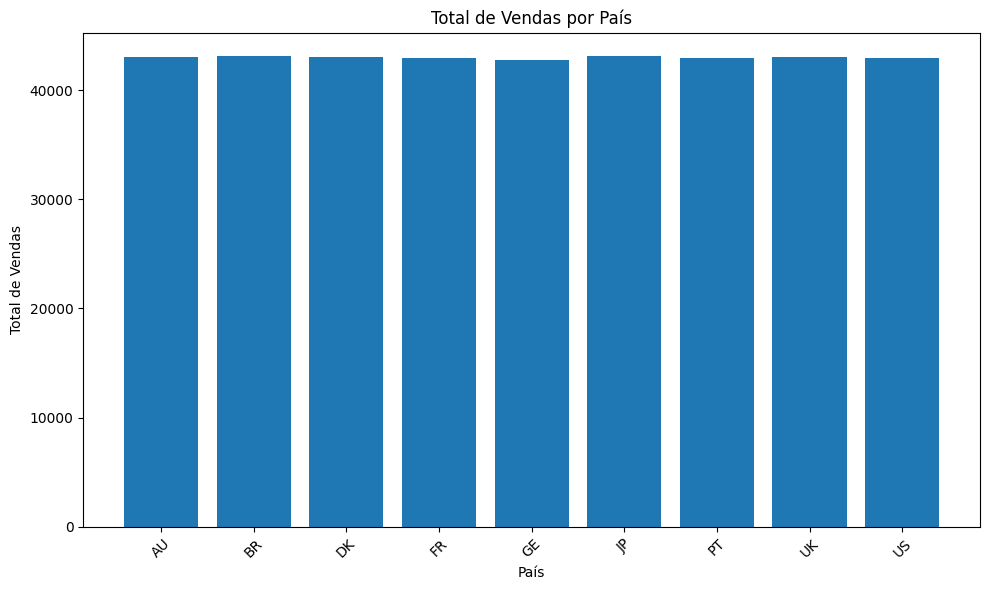

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from collections import Counter

# Carregar os dados dos arquivos CSV
produtos = pd.read_csv('/content/drive/MyDrive/teste/produtos.csv')
vendas = pd.read_csv('/content/drive/MyDrive/teste/vendas.csv')

# Combinar os DataFrames usando a chave 'Codigo'
df = pd.merge(vendas, produtos, left_on='Codigo', right_on='Codigo')

# 1) Produto mais vendido em termos de quantidade:
mais_vendido = df.groupby('Produto').sum().sort_values(by='Qty', ascending=False).head(1)

# 2) Total de vendas por país:
total_vendas_por_pais = df.groupby('ship-country')['Qty'].sum().reset_index()

# 3) Faturamento total por produto:
df['Faturamento Total'] = df['Qty'] * df['Preco'].str.replace('[\$,]', '', regex=True).astype(float)
faturamento_por_produto = df.groupby('Produto')['Faturamento Total'].sum().reset_index()

# 4) Estilo de produto mais popular em março de 2022:
estilo_mais_popular = df[df['Date'].str.startswith('2022-03')].groupby('Style')['Qty'].sum().reset_index().sort_values(by='Qty', ascending=False).head(1)

# 5) Nível de envio mais comum:
nivel_envio_mais_comum = df['ship-service-level'].value_counts().idxmax()

# 6) Produto com o preço mais alto:
produto_mais_caro = df.sort_values(by='Preco', ascending=False).head(1)[['Produto', 'Preco']]

# 7) Dia da semana com maior volume de vendas:
df['Date'] = pd.to_datetime(df['Date'])
df['Dia da Semana'] = df['Date'].dt.day_name()
dia_semana_mais_vendido = df.groupby('Dia da Semana')['Qty'].sum().idxmax()

# 8) Produtos mais frequentemente vendidos juntos:
counter = Counter()
for _, group in df.groupby('Order ID'):
    products = group['Produto']
    counter.update(combinations(products, 2))

produtos_mais_frequentes = counter.most_common(5)

# 9) País com o maior número de transações rejeitadas:
if 'REJECTED' in df['Fulfillment'].unique():
    pais_mais_rejeicoes = df[df['Fulfillment'] == 'REJECTED']['ship-country'].value_counts().idxmax()
else:
    pais_mais_rejeicoes = "Nenhum país tem transações rejeitadas"

# 10) Total de vendas por ano:
df['Ano'] = df['Date'].dt.year
total_vendas_por_ano = df.groupby('Ano')['Qty'].sum().reset_index()

# 11) Estilo de produto mais rentável em termos de faturamento:
estilo_mais_rentavel = df.groupby('Style')['Faturamento Total'].sum().idxmax()

# 12) Produto com a maior média de vendas diárias:
media_vendas_diarias = df.groupby('Produto')['Qty'].mean().idxmax()

# 13) Ticket médio de todas as vendas:
ticket_medio = df['Faturamento Total'].sum() / df['Qty'].sum()

# 14) País com o maior número de transações:
pais_maior_numero_transacoes = df['ship-country'].value_counts().idxmax()

# 15) Média de produtos vendidos por transação em cada país:
media_produtos_por_transacao = df.groupby('ship-country')['Qty'].mean().reset_index()
media_produtos_por_transacao = media_produtos_por_transacao.rename(columns={'Qty': 'Media de Produtos por Transacao'})

# Exibindo as respostas
print("1) Produto mais vendido em termos de quantidade:\n", mais_vendido)
print("\n2) Total de vendas por país:\n", total_vendas_por_pais)
print("\n3) Faturamento total por produto:\n", faturamento_por_produto)
print("\n4) Estilo de produto mais popular em março de 2022:\n", estilo_mais_popular)
print("\n5) Nível de envio mais comum:\n", nivel_envio_mais_comum)
print("\n6) Produto com o preço mais alto:\n", produto_mais_caro)
print("\n7) Dia da semana com maior volume de vendas:\n", dia_semana_mais_vendido)
print("\n8) Produtos mais frequentemente vendidos juntos:\n", produtos_mais_frequentes)
print("\n9) País com o maior número de transações rejeitadas:\n", pais_mais_rejeicoes)
print("\n10) Total de vendas por ano:\n", total_vendas_por_ano)
print("\n11) Estilo de produto mais rentável em termos de faturamento:\n", estilo_mais_rentavel)
print("\n12) Produto com a maior média de vendas diárias:\n", media_vendas_diarias)
print("\n13) Ticket médio de todas as vendas:\n", ticket_medio)
print("\n14) País com o maior número de transações:\n", pais_maior_numero_transacoes)
print("\n15) Média de produtos vendidos por transação em cada país:\n", media_produtos_por_transacao)

# Visualização de dados
# Gráfico: Total de vendas por país
plt.figure(figsize=(10, 6))
plt.bar(total_vendas_por_pais['ship-country'], total_vendas_por_pais['Qty'])
plt.xlabel('País')
plt.ylabel('Total de Vendas')
plt.title('Total de Vendas por País')
plt.xticks(rotation=45)  # Rotacionar os rótulos do eixo x para melhor legibilidade
plt.tight_layout()  # Ajustar layout para evitar cortar as legendas
plt.show()
